In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
from numpy.linalg import norm
from numpy import trace
from numpy import identity
from numpy import argpartition
from numpy.linalg import multi_dot
from scipy.linalg import hadamard
from copy import deepcopy

import matplotlib.pyplot as plt

In [4]:
from pyqalm.data_structures import SparseFactors
from pyqalm.qalm import palm4msa_fast1, PALM4MSA

In [5]:
def get_data(small_dim=2**10, large_dim=2**11, n_nonzeros_small=None, n_nonzeros_large=None):
    if n_nonzeros_small is None:
        n_nonzeros_small = 2*small_dim
    if n_nonzeros_large is None:
        n_nonzeros_large = 2*large_dim
    n_factors = int(np.log2(small_dim))
    A = []
    for _ in range(n_factors - 1):
        A.append(np.zeros((small_dim, small_dim)))
        A[-1].flat[np.random.choice(small_dim**2, size=n_nonzeros_small)] = np.random.randn(n_nonzeros_small)
    A += [np.zeros((small_dim, large_dim))]
    A[-1].flat[np.random.choice(small_dim * large_dim, size=n_nonzeros_large)] = np.random.randn(n_nonzeros_large)
    P = np.linalg.multi_dot(A)
    S = SparseFactors(A)
    return A, P, S

# Execution time for computing a matrix-vector product

In [ ]:
print('Execution time for computing a matrix-vector product (square case)')
lst_small_dim = 2**np.arange(8, 13)
times = np.empty((len(lst_small_dim), 4))
for i, small_dim in enumerate(lst_small_dim):
    large_dim = small_dim
    print('Dimension:', small_dim, large_dim)
    A, P, S = get_data(small_dim=small_dim, 
                       large_dim=large_dim, 
                       n_nonzeros_small=2*small_dim, 
                       n_nonzeros_large=2*large_dim)
    x = np.random.randn(large_dim)
    t = %timeit -o y = P @ x
    times[i, 0] = t.average
    t = %timeit -o y = S(x)
    times[i, 1] = t.average
    t = %timeit -o y = S @ x
    times[i, 2] = t.average
    t = %timeit -o y = S.matvec(x)
    times[i, 3] = t.average

In [ ]:
plt.loglog(lst_small_dim, times[:, 0], label='dense')
plt.loglog(lst_small_dim, times[:, 1], label='Sparse: call')
plt.loglog(lst_small_dim, times[:, 2], label='Sparse: @')
plt.loglog(lst_small_dim, times[:, 3], label='Sparse: matvec')
plt.legend()
plt.grid()
plt.title('Execution time for computing a matrix-vector product (square case)')
plt.ylabel('Running time (s)')
plt.xlabel('Data dimension $n$ ($n \times n$)')

In [ ]:
print('Execution time for computing a matrix-vector product (rectangular case)')
lst_small_dim = 2**np.arange(8, 13)
times = np.empty((len(lst_small_dim), 4))
for i, small_dim in enumerate(lst_small_dim):
    large_dim = small_dim * 4
    print('Dimension:', small_dim, large_dim)
    A, P, S = get_data(small_dim=small_dim, 
                       large_dim=large_dim, 
                       n_nonzeros_small=2*small_dim, 
                       n_nonzeros_large=2*large_dim)
    x = np.random.randn(large_dim)
    t = %timeit -o y = P @ x
    times[i, 0] = t.average
    t = %timeit -o y = S(x)
    times[i, 1] = t.average
    t = %timeit -o y = S @ x
    times[i, 2] = t.average
    t = %timeit -o y = S.matvec(x)
    times[i, 3] = t.average

In [ ]:
plt.loglog(lst_small_dim, times[:, 0], label='dense')
plt.loglog(lst_small_dim, times[:, 1], label='Sparse: call')
plt.loglog(lst_small_dim, times[:, 2], label='Sparse: @')
plt.loglog(lst_small_dim, times[:, 3], label='Sparse: matvec')
plt.legend()
plt.grid()
plt.title('Execution time for computing a matrix-vector product (rectangular case)')
plt.ylabel('Running time (s)')
plt.xlabel('Data dimension $n$ ($n \times 4n$)')

# Execution time for computing the spectral norm

In [ ]:
print('Execution time for computing the spectral norm (rectangular case)')
lst_small_dim = 2**np.arange(8, 13)
times = np.empty((len(lst_small_dim), 4))
for i, small_dim in enumerate(lst_small_dim):
    large_dim = small_dim * 4
    print('Dimension:', small_dim, large_dim)
    A, P, S = get_data(small_dim=small_dim, 
                       large_dim=large_dim, 
                       n_nonzeros_small=2*small_dim, 
                       n_nonzeros_large=2*large_dim)
    SH = S.adjoint()
    t = %timeit -o np.linalg.norm(P, ord=2)
    times[i, 0] = t.average
    t = %timeit -o S.compute_spectral_norm(method='svds')
    times[i, 1] = t.average
    t = %timeit -o S.compute_spectral_norm(method='eigs')
    times[i, 2] = t.average
    t = %timeit -o SH.compute_spectral_norm(method='eigs')
    times[i, 3] = t.average

In [ ]:
plt.loglog(lst_small_dim, times[:, 0], label='dense')
plt.loglog(lst_small_dim, times[:, 1], label='Sparse: svds')
plt.loglog(lst_small_dim, times[:, 2], label='Sparse: eigs')
plt.loglog(lst_small_dim, times[:, 3], label='Sparse (Hermitian): eigs')
plt.legend()
plt.grid()
plt.title('Execution time for computing a matrix-vector product (rectangular case)')
plt.ylabel('Running time (s)')
plt.xlabel('Data dimension $n$ ($n \times 4n$)')

# Execution time for computing the product

In [6]:
print('Execution time for computing the product')
lst_small_dim = 2**np.arange(8, 13)
times = np.empty((len(lst_small_dim), 2))
for i, small_dim in enumerate(lst_small_dim):
    large_dim = small_dim * 4
    print('Dimension:', small_dim, large_dim)
    A, P, S = get_data(small_dim=small_dim, 
                       large_dim=large_dim, 
                       n_nonzeros_small=2*small_dim, 
                       n_nonzeros_large=2*large_dim)
    t = %timeit -o P = np.linalg.multi_dot(A)
    times[i, 0] = t.average
    t = %timeit -o PP = S.compute_product()
    times[i, 1] = t.average

Execution time for computing the product
Dimension: 256 1024
7.85 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.73 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Dimension: 512 2048
66.3 ms ± 6.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.1 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Dimension: 1024 4096
511 ms ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
65 ms ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Dimension: 2048 8192
5.06 s ± 1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
572 ms ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Dimension: 4096 16384
35.8 s ± 1.21 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.7 s ± 83.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5,1,'Execution time for computing the product (rectangular case)')

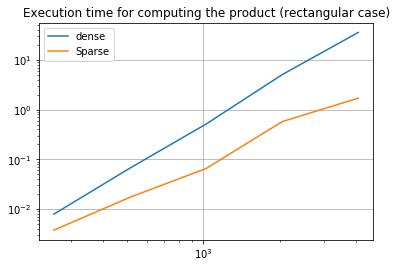

In [10]:
plt.loglog(lst_small_dim, times[:, 0], label='dense')
plt.loglog(lst_small_dim, times[:, 1], label='Sparse')
plt.legend()
plt.grid()
plt.title('Execution time for computing the product (rectangular case)')
plt.ylabel('Running time (s)')
plt.xlabel('Data dimension $n$ ($n \times 4n$)')

# Execution time for `palm4msa`

In [22]:
from pyqalm.qalm import palm4msa_fast1, PALM4MSA
from pyqalm.utils import get_lambda_proxsplincol


In [24]:
print('Execution time for palm4msa')
lst_small_dim = 2**np.arange(7, 11)
times = np.empty((len(lst_small_dim), 2))
for i, small_dim in enumerate(lst_small_dim):
    large_dim = small_dim
    X = hadamard(small_dim)
    print('Dimension:', small_dim, large_dim)
    
    d = np.min(X.shape)
    if X.shape[1] == d:
        X = X.T
    nb_factors = int(np.log2(d))
    lst_S_init = []
    for _ in range(nb_factors - 1):
        lst_S_init.append(np.eye(d))
    lst_S_init.append(np.zeros(X.shape))

    nb_keep_values = 2 * d
    nb_values_residual = int(d / 2 ** nb_factors) * d
    lst_projection_functions = \
        [get_lambda_proxsplincol(nb_keep_values)] * nb_factors \
        + [get_lambda_proxsplincol(nb_values_residual)]

    f_lambda_init = 1
    nb_iter = 10
    update_right_to_left = True
    graphical_display = False
    
    t = %timeit -o f_lambda_ref, lst_S_ref, arr_X_curr_ref, objective_function_ref, i_iter_ref = \
        PALM4MSA(X, \
                 lst_S_init=lst_S_init, \
                 nb_factors=nb_factors, \
                 lst_projection_functions=lst_projection_functions, \
                 f_lambda_init=f_lambda_init, \
                 nb_iter=nb_iter, \
                 update_right_to_left=update_right_to_left, \
                 graphical_display=graphical_display)
    times[i, 0] = t.average

    t = %timeit -o f_lambda, lst_S, arr_X_curr, objective_function, i_iter = \
        palm4msa_fast1(X, \
                       lst_S_init=lst_S_init, \
                       nb_factors=nb_factors, \
                       lst_projection_functions=lst_projection_functions, \
                       f_lambda_init=f_lambda_init, \
                       nb_iter=nb_iter, \
                       update_right_to_left=update_right_to_left, \
                       graphical_display=graphical_display)
    times[i, 1] = t.average

2019-05-21 16:33:54,385 [84632] DEBUG    pyqalm: Norme de arr_X_target: 256.0
2019-05-21 16:33:54,421 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1.0; c value: 1.001
2019-05-21 16:33:54,463 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.5312652550071837; c value: 0.5317965202621908
2019-05-21 16:33:54,529 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.3053311015382428; c value: 0.30563643263978096


Execution time for palm4msa
Dimension: 256 256


2019-05-21 16:33:54,579 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.23334435541806153; c value: 0.23357769977347956
2019-05-21 16:33:54,621 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.18924657830440703; c value: 0.1894358248827114
2019-05-21 16:33:54,657 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.15917876502154651; c value: 0.15933794378656804
2019-05-21 16:33:54,698 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.13735544984685408; c value: 0.1374928052967009
2019-05-21 16:33:54,738 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.12079436241266507; c value: 0.12091515677507772
2019-05-21 16:33:54,758 [84632] DEBUG    pyqalm: Lambda value: 48.73227461713903
2019-05-21 16:33:54,770 [84632] DEBUG    pyqalm: Iteration 0; Objective value: 65280.000010089345
2019-05-21 16:33:54,812 [84632] DEBUG    pyqalm: Lipsitchz constant value: 507.25068508908043; c value: 507.7579357741695
2019-05-21 16:33:54,856 [84632] DEBUG    pyqalm: Lipsitchz constant value: 4

2019-05-21 16:33:57,361 [84632] DEBUG    pyqalm: Lipsitchz constant value: 314.29521610751806; c value: 314.60951132362555
2019-05-21 16:33:57,406 [84632] DEBUG    pyqalm: Lipsitchz constant value: 303.2941929118618; c value: 303.5974871047736
2019-05-21 16:33:57,447 [84632] DEBUG    pyqalm: Lipsitchz constant value: 295.80201024805206; c value: 296.09781225830005
2019-05-21 16:33:57,484 [84632] DEBUG    pyqalm: Lipsitchz constant value: 290.3594258184195; c value: 290.6497852442379
2019-05-21 16:33:57,525 [84632] DEBUG    pyqalm: Lipsitchz constant value: 286.2262729300755; c value: 286.5124992030055
2019-05-21 16:33:57,546 [84632] DEBUG    pyqalm: Lambda value: 48.78090441944503
2019-05-21 16:33:57,560 [84632] DEBUG    pyqalm: Iteration 1; Objective value: 65279.99999999446
2019-05-21 16:33:57,563 [84632] DEBUG    pyqalm: Norme de arr_X_target: 256.0
2019-05-21 16:33:57,598 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1.0; c value: 1.001
2019-05-21 16:33:57,630 [84632] DEBUG   

2019-05-21 16:34:00,497 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.5312652550071837; c value: 0.5317965202621908
2019-05-21 16:34:00,548 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.3053311015382428; c value: 0.30563643263978096
2019-05-21 16:34:00,607 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.23334435541806153; c value: 0.23357769977347956
2019-05-21 16:34:00,660 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.18924657830440703; c value: 0.1894358248827114
2019-05-21 16:34:00,706 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.15917876502154651; c value: 0.15933794378656804
2019-05-21 16:34:00,757 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.13735544984685408; c value: 0.1374928052967009
2019-05-21 16:34:00,808 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.12079436241266507; c value: 0.12091515677507772
2019-05-21 16:34:00,840 [84632] DEBUG    pyqalm: Lambda value: 48.73227461713903
2019-05-21 16:34:00,854 [84632] DEBUG    pyqalm: 

878 ms ± 95.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2019-05-21 16:34:01,545 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.18924657830440875; c value: 0.18943582488271313
2019-05-21 16:34:01,604 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.15917876502154374; c value: 0.15933794378656527
2019-05-21 16:34:01,642 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.13735544984685374; c value: 0.13749280529670058
2019-05-21 16:34:01,680 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.12079436241267083; c value: 0.1209151567750835
2019-05-21 16:34:01,715 [84632] DEBUG    pyqalm: Lambda value: 48.73227461713903
2019-05-21 16:34:01,730 [84632] DEBUG    pyqalm: Iteration 0; Objective value: 65280.000010089345
2019-05-21 16:34:01,755 [84632] DEBUG    pyqalm: Lipsitchz constant value: 507.25068508908475; c value: 507.7579357741738
2019-05-21 16:34:01,804 [84632] DEBUG    pyqalm: Lipsitchz constant value: 419.2404826259265; c value: 419.6597231085524
2019-05-21 16:34:01,866 [84632] DEBUG    pyqalm: Lipsitchz constant value: 333.

2019-05-21 16:34:04,346 [84632] DEBUG    pyqalm: Lipsitchz constant value: 303.2941929118624; c value: 303.59748710477425
2019-05-21 16:34:04,390 [84632] DEBUG    pyqalm: Lipsitchz constant value: 295.80201024804586; c value: 296.09781225829386
2019-05-21 16:34:04,429 [84632] DEBUG    pyqalm: Lipsitchz constant value: 290.3594258184238; c value: 290.6497852442422
2019-05-21 16:34:04,461 [84632] DEBUG    pyqalm: Lipsitchz constant value: 286.2262729300732; c value: 286.51249920300324
2019-05-21 16:34:04,494 [84632] DEBUG    pyqalm: Lambda value: 48.78090441944503
2019-05-21 16:34:04,510 [84632] DEBUG    pyqalm: Iteration 1; Objective value: 65279.99999999446
2019-05-21 16:34:04,514 [84632] DEBUG    pyqalm: Norme de arr_X_target: 256.0
2019-05-21 16:34:04,558 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1.0; c value: 1.001
2019-05-21 16:34:04,589 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.5312652550071844; c value: 0.5317965202621915
2019-05-21 16:34:04,623 [84632] DEBUG 

2019-05-21 16:34:06,598 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.23334435541806767; c value: 0.23357769977348572
2019-05-21 16:34:06,630 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.18924657830440406; c value: 0.18943582488270844
2019-05-21 16:34:06,660 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.15917876502154418; c value: 0.1593379437865657
2019-05-21 16:34:06,697 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.1373554498468551; c value: 0.13749280529670194
2019-05-21 16:34:06,719 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.12079436241266928; c value: 0.12091515677508194
2019-05-21 16:34:06,746 [84632] DEBUG    pyqalm: Lambda value: 48.73227461713903
2019-05-21 16:34:06,757 [84632] DEBUG    pyqalm: Iteration 0; Objective value: 65280.000010089345
2019-05-21 16:34:06,773 [84632] DEBUG    pyqalm: Lipsitchz constant value: 507.25068508909646; c value: 507.7579357741855
2019-05-21 16:34:06,811 [84632] DEBUG    pyqalm: Lipsitchz constant value: 4

715 ms ± 87.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Dimension: 512 512


2019-05-21 16:34:07,501 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1.0; c value: 1.001
2019-05-21 16:34:07,753 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.5221024810451502; c value: 0.5226245835261953
2019-05-21 16:34:08,015 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.3122937215341142; c value: 0.3126060152556483
2019-05-21 16:34:08,215 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.23764926612057122; c value: 0.23788691538669177
2019-05-21 16:34:08,469 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.19200974603540383; c value: 0.19220175578143922
2019-05-21 16:34:08,722 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.16107984980064471; c value: 0.16124092965044534
2019-05-21 16:34:08,939 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.13873211589620568; c value: 0.13887084801210187
2019-05-21 16:34:09,111 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.12182972863522834; c value: 0.12195155836386355
2019-05-21 16:34:09,275 [84632] DE

2019-05-21 16:34:19,475 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.19200974603540383; c value: 0.19220175578143922
2019-05-21 16:34:19,638 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.16107984980064471; c value: 0.16124092965044534
2019-05-21 16:34:19,799 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.13873211589620568; c value: 0.13887084801210187
2019-05-21 16:34:20,020 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.12182972863522834; c value: 0.12195155836386355
2019-05-21 16:34:20,184 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.10859858133854407; c value: 0.1087071799198826
2019-05-21 16:34:20,289 [84632] DEBUG    pyqalm: Lambda value: 72.2954810486238
2019-05-21 16:34:20,350 [84632] DEBUG    pyqalm: Iteration 0; Objective value: 261632.0000029533
2019-05-21 16:34:20,487 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1019.163396043836; c value: 1020.1825594398797
2019-05-21 16:34:20,696 [84632] DEBUG    pyqalm: Lipsitchz constant value: 81

2019-05-21 16:34:32,802 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.12182972863522834; c value: 0.12195155836386355
2019-05-21 16:34:33,103 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.10859858133854407; c value: 0.1087071799198826
2019-05-21 16:34:33,251 [84632] DEBUG    pyqalm: Lambda value: 72.2954810486238
2019-05-21 16:34:33,322 [84632] DEBUG    pyqalm: Iteration 0; Objective value: 261632.0000029533
2019-05-21 16:34:33,460 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1019.163396043836; c value: 1020.1825594398797
2019-05-21 16:34:33,657 [84632] DEBUG    pyqalm: Lipsitchz constant value: 819.7526584209589; c value: 820.5724110793798
2019-05-21 16:34:33,857 [84632] DEBUG    pyqalm: Lipsitchz constant value: 670.8399358202965; c value: 671.5107757561168
2019-05-21 16:34:34,044 [84632] DEBUG    pyqalm: Lipsitchz constant value: 632.2809628924741; c value: 632.9132438553665
2019-05-21 16:34:34,233 [84632] DEBUG    pyqalm: Lipsitchz constant value: 609.2078241229

3.92 s ± 412 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2019-05-21 16:34:38,829 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.3122937215341238; c value: 0.3126060152556579
2019-05-21 16:34:38,890 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.2376492661205579; c value: 0.23788691538667842
2019-05-21 16:34:38,966 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.19200974603540055; c value: 0.19220175578143595
2019-05-21 16:34:39,038 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.1610798498006374; c value: 0.16124092965043801
2019-05-21 16:34:39,114 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.13873211589622164; c value: 0.13887084801211785
2019-05-21 16:34:39,193 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.12182972863523733; c value: 0.12195155836387256
2019-05-21 16:34:39,271 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.10859858133854579; c value: 0.10870717991988432
2019-05-21 16:34:39,381 [84632] DEBUG    pyqalm: Lambda value: 72.29548104862681
2019-05-21 16:34:39,416 [84632] DEBUG    pyqalm:

2019-05-21 16:34:44,864 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.16107984980064669; c value: 0.1612409296504473
2019-05-21 16:34:44,946 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.13873211589621168; c value: 0.13887084801210786
2019-05-21 16:34:45,027 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.12182972863523206; c value: 0.12195155836386729
2019-05-21 16:34:45,109 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.10859858133855241; c value: 0.10870717991989094
2019-05-21 16:34:45,210 [84632] DEBUG    pyqalm: Lambda value: 72.29548104862681
2019-05-21 16:34:45,276 [84632] DEBUG    pyqalm: Iteration 0; Objective value: 261632.0000029533
2019-05-21 16:34:45,323 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1019.1633960440428; c value: 1020.1825594400867
2019-05-21 16:34:45,501 [84632] DEBUG    pyqalm: Lipsitchz constant value: 819.7526584210979; c value: 820.5724110795188
2019-05-21 16:34:45,648 [84632] DEBUG    pyqalm: Lipsitchz constant value: 670.

2019-05-21 16:34:51,102 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.10859858133854923; c value: 0.10870717991988776
2019-05-21 16:34:51,199 [84632] DEBUG    pyqalm: Lambda value: 72.29548104862681
2019-05-21 16:34:51,230 [84632] DEBUG    pyqalm: Iteration 0; Objective value: 261632.0000029533
2019-05-21 16:34:51,247 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1019.1633960439641; c value: 1020.1825594400079
2019-05-21 16:34:51,338 [84632] DEBUG    pyqalm: Lipsitchz constant value: 819.7526584211305; c value: 820.5724110795516
2019-05-21 16:34:51,422 [84632] DEBUG    pyqalm: Lipsitchz constant value: 670.8399358203401; c value: 671.5107757561603
2019-05-21 16:34:51,506 [84632] DEBUG    pyqalm: Lipsitchz constant value: 632.2809628925515; c value: 632.9132438554441
2019-05-21 16:34:51,595 [84632] DEBUG    pyqalm: Lipsitchz constant value: 609.2078241229701; c value: 609.817031947093
2019-05-21 16:34:51,773 [84632] DEBUG    pyqalm: Lipsitchz constant value: 593.572943842518

1.99 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Dimension: 1024 1024


2019-05-21 16:34:56,948 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1.0; c value: 1.001
2019-05-21 16:34:59,064 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.5156269072317755; c value: 0.5161425341390072
2019-05-21 16:35:01,069 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.31779703479657767; c value: 0.31811483183137423
2019-05-21 16:35:02,946 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.24094102996358063; c value: 0.2411819709935442
2019-05-21 16:35:04,666 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.19412023564879013; c value: 0.1943143558844389
2019-05-21 16:35:06,557 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.16253691814144092; c value: 0.16269945505958233
2019-05-21 16:35:08,205 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.13979263593038396; c value: 0.13993242856631433
2019-05-21 16:35:10,384 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.12263228387109201; c value: 0.12275491615496309
2019-05-21 16:35:12,138 [84632] DE

2019-05-21 16:36:48,165 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1124.395060344491; c value: 1125.5194554048353
2019-05-21 16:36:48,970 [84632] DEBUG    pyqalm: Lambda value: 106.91197688490175
2019-05-21 16:36:49,443 [84632] DEBUG    pyqalm: Iteration 1; Objective value: 1047552.0000001285
2019-05-21 16:36:49,460 [84632] DEBUG    pyqalm: Norme de arr_X_target: 1024.0
2019-05-21 16:36:51,238 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1.0; c value: 1.001
2019-05-21 16:36:52,733 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.5156269072317755; c value: 0.5161425341390072
2019-05-21 16:36:54,214 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.31779703479657767; c value: 0.31811483183137423
2019-05-21 16:36:56,357 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.24094102996358063; c value: 0.2411819709935442
2019-05-21 16:36:58,286 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.19412023564879013; c value: 0.1943143558844389
2019-05-21 16:37:00,172 [846

2019-05-21 16:39:00,376 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1166.5122507579154; c value: 1167.678763008673
2019-05-21 16:39:02,057 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1149.0284986792744; c value: 1150.1775271779536
2019-05-21 16:39:03,923 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1135.3658566362983; c value: 1136.5012224929344
2019-05-21 16:39:05,842 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1124.395060344491; c value: 1125.5194554048353
2019-05-21 16:39:06,794 [84632] DEBUG    pyqalm: Lambda value: 106.91197688490175
2019-05-21 16:39:07,346 [84632] DEBUG    pyqalm: Iteration 1; Objective value: 1047552.0000001285
2019-05-21 16:39:07,375 [84632] DEBUG    pyqalm: Norme de arr_X_target: 1024.0
2019-05-21 16:39:09,672 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1.0; c value: 1.001
2019-05-21 16:39:11,597 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.5156269072317755; c value: 0.5161425341390072
2019-05-21 16:39:13,833 [84632] D

41.3 s ± 6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


2019-05-21 16:40:23,999 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1.0; c value: 1.001
2019-05-21 16:40:24,181 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.5156269072317813; c value: 0.516142534139013
2019-05-21 16:40:24,399 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.31779703479657767; c value: 0.31811483183137423
2019-05-21 16:40:24,606 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.24094102996358663; c value: 0.24118197099355018
2019-05-21 16:40:24,870 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.194120235648796; c value: 0.19431435588444476
2019-05-21 16:40:25,142 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.1625369181413736; c value: 0.16269945505951497
2019-05-21 16:40:25,404 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.1397926359303194; c value: 0.1399324285662497
2019-05-21 16:40:25,687 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.1226322838710323; c value: 0.12275491615490332
2019-05-21 16:40:25,959 [84632] DEBUG  

2019-05-21 16:40:42,004 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1124.3950603448557; c value: 1125.5194554052005
2019-05-21 16:40:42,414 [84632] DEBUG    pyqalm: Lambda value: 106.911976884915
2019-05-21 16:40:42,528 [84632] DEBUG    pyqalm: Iteration 1; Objective value: 1047552.0000001285
2019-05-21 16:40:42,533 [84632] DEBUG    pyqalm: Norme de arr_X_target: 1024.0
2019-05-21 16:40:43,003 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1.0; c value: 1.001
2019-05-21 16:40:43,162 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.5156269072317836; c value: 0.5161425341390153
2019-05-21 16:40:43,367 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.31779703479659344; c value: 0.31811483183139
2019-05-21 16:40:43,565 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.24094102996356032; c value: 0.24118197099352384
2019-05-21 16:40:43,824 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.1941202356487877; c value: 0.19431435588443646
2019-05-21 16:40:44,087 [84632]

2019-05-21 16:41:00,163 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1166.5122507582237; c value: 1167.6787630089818
2019-05-21 16:41:00,478 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1149.0284986798472; c value: 1150.1775271785268
2019-05-21 16:41:00,782 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1135.3658566368906; c value: 1136.5012224935274
2019-05-21 16:41:01,074 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1124.3950603453645; c value: 1125.5194554057098
2019-05-21 16:41:01,467 [84632] DEBUG    pyqalm: Lambda value: 106.911976884915
2019-05-21 16:41:01,579 [84632] DEBUG    pyqalm: Iteration 1; Objective value: 1047552.0000001285
2019-05-21 16:41:01,584 [84632] DEBUG    pyqalm: Norme de arr_X_target: 1024.0
2019-05-21 16:41:02,053 [84632] DEBUG    pyqalm: Lipsitchz constant value: 1.0; c value: 1.001
2019-05-21 16:41:02,219 [84632] DEBUG    pyqalm: Lipsitchz constant value: 0.5156269072317773; c value: 0.516142534139009
2019-05-21 16:41:02,420 [84632] DE

6.35 s ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5,0,'Data dimension')

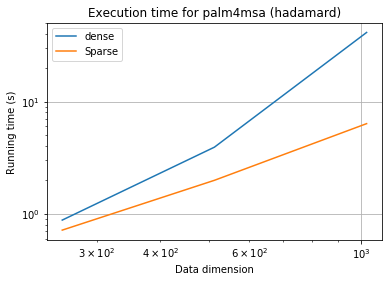

In [25]:
plt.loglog(lst_small_dim, times[:, 0], label='dense')
plt.loglog(lst_small_dim, times[:, 1], label='Sparse')
plt.legend()
plt.grid()
plt.title('Execution time for palm4msa (hadamard)')
plt.ylabel('Running time (s)')
plt.xlabel('Data dimension')